# 1.正则化之weight_decay

Q:weight_decay的代码示例？

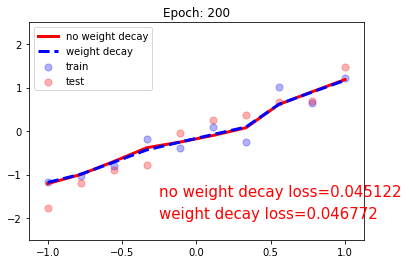

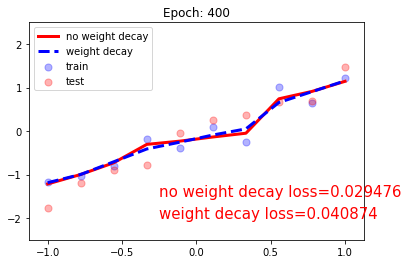

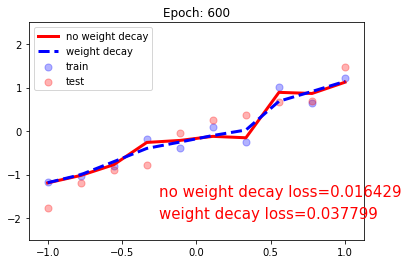

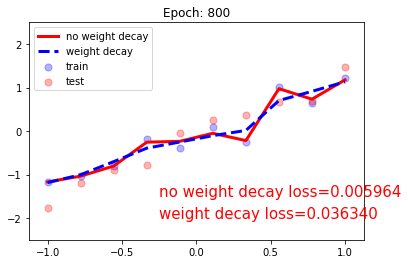

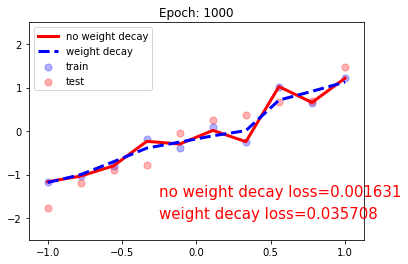

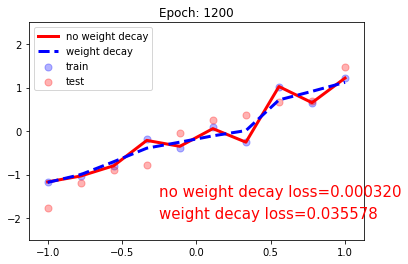

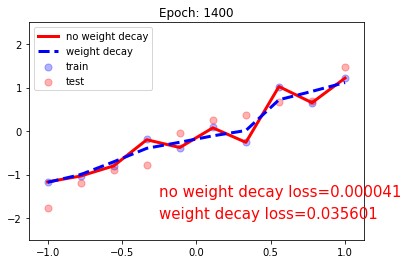

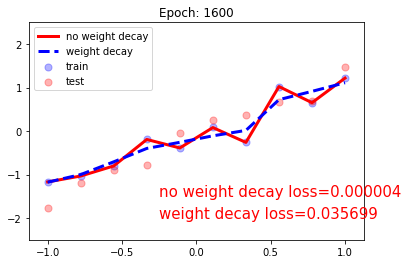

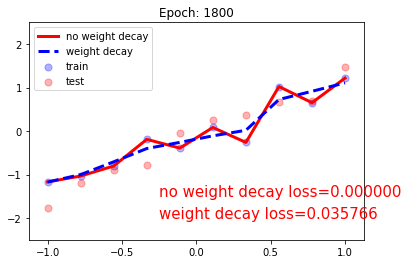

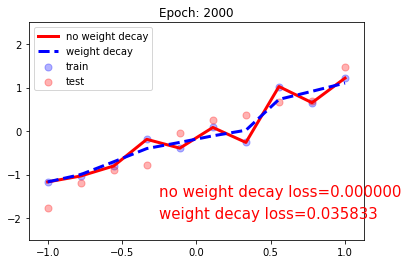

In [1]:
"""
@file name  : L2_regularization.py
# @author   : TingsongYu https://github.com/TingsongYu
@date       : 2019-10-30
@brief      : weight decay使用实验
"""
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from utils.common_tools import set_seed
from torch.utils.tensorboard import SummaryWriter

set_seed(1)  # 设置随机种子
n_hidden = 200
max_iter = 2000
disp_interval = 200
lr_init = 0.01


# ============================ step 1/5 数据 ============================
def gen_data(num_data=10, x_range=(-1, 1)):

    w = 1.5
    train_x = torch.linspace(*x_range, num_data).unsqueeze_(1)
    train_y = w*train_x + torch.normal(0, 0.5, size=train_x.size())
    test_x = torch.linspace(*x_range, num_data).unsqueeze_(1)
    test_y = w*test_x + torch.normal(0, 0.3, size=test_x.size())

    return train_x, train_y, test_x, test_y


train_x, train_y, test_x, test_y = gen_data(x_range=(-1, 1))


# ============================ step 2/5 模型 ============================
class MLP(nn.Module):
    def __init__(self, neural_num):
        super(MLP, self).__init__()
        self.linears = nn.Sequential(
            nn.Linear(1, neural_num),
            nn.ReLU(inplace=True),
            nn.Linear(neural_num, neural_num),
            nn.ReLU(inplace=True),
            nn.Linear(neural_num, neural_num),
            nn.ReLU(inplace=True),
            nn.Linear(neural_num, 1),
        )

    def forward(self, x):
        return self.linears(x)


net_normal = MLP(neural_num=n_hidden)
net_weight_decay = MLP(neural_num=n_hidden)

# ============================ step 3/5 优化器 ============================
optim_normal = torch.optim.SGD(net_normal.parameters(), lr=lr_init, momentum=0.9)
optim_wdecay = torch.optim.SGD(net_weight_decay.parameters(), lr=lr_init, momentum=0.9, weight_decay=1e-2)

# ============================ step 4/5 损失函数 ============================
loss_func = torch.nn.MSELoss()

# ============================ step 5/5 迭代训练 ============================

writer = SummaryWriter(comment='_test_tensorboard', filename_suffix="12345678")
for epoch in range(max_iter):

    # forward
    pred_normal, pred_wdecay = net_normal(train_x), net_weight_decay(train_x)
    loss_normal, loss_wdecay = loss_func(pred_normal, train_y), loss_func(pred_wdecay, train_y)

    optim_normal.zero_grad()
    optim_wdecay.zero_grad()

    loss_normal.backward()
    loss_wdecay.backward()

    optim_normal.step()
    optim_wdecay.step()

    if (epoch+1) % disp_interval == 0:

        # 可视化
        for name, layer in net_normal.named_parameters():
            writer.add_histogram(name + '_grad_normal', layer.grad, epoch)
            writer.add_histogram(name + '_data_normal', layer, epoch)

        for name, layer in net_weight_decay.named_parameters():
            writer.add_histogram(name + '_grad_weight_decay', layer.grad, epoch)
            writer.add_histogram(name + '_data_weight_decay', layer, epoch)

        test_pred_normal, test_pred_wdecay = net_normal(test_x), net_weight_decay(test_x)

        # 绘图
        plt.scatter(train_x.data.numpy(), train_y.data.numpy(), c='blue', s=50, alpha=0.3, label='train')
        plt.scatter(test_x.data.numpy(), test_y.data.numpy(), c='red', s=50, alpha=0.3, label='test')
        plt.plot(test_x.data.numpy(), test_pred_normal.data.numpy(), 'r-', lw=3, label='no weight decay')
        plt.plot(test_x.data.numpy(), test_pred_wdecay.data.numpy(), 'b--', lw=3, label='weight decay')
        plt.text(-0.25, -1.5, 'no weight decay loss={:.6f}'.format(loss_normal.item()), fontdict={'size': 15, 'color': 'red'})
        plt.text(-0.25, -2, 'weight decay loss={:.6f}'.format(loss_wdecay.item()), fontdict={'size': 15, 'color': 'red'})

        plt.ylim((-2.5, 2.5))
        plt.legend(loc='upper left')
        plt.title("Epoch: {}".format(epoch+1))
        plt.show()
        plt.close()

# 2.正则化之Dropout

Q:dropout代码示例

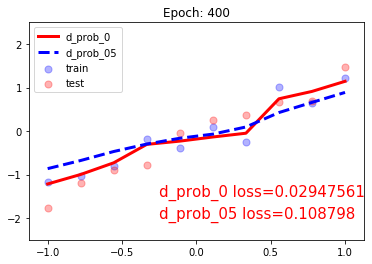

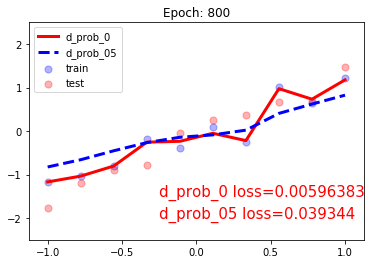

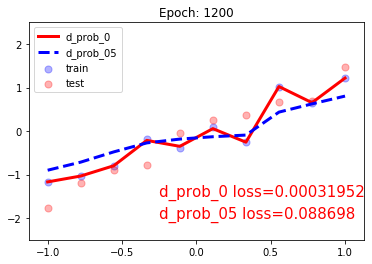

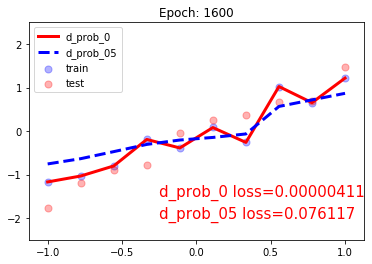

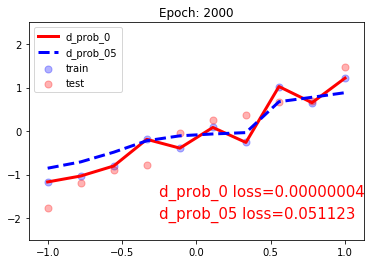

In [2]:
# -*- coding:utf-8 -*-
"""
@file name  : dropout_regularization.py
# @author   : TingsongYu https://github.com/TingsongYu
@date       : 2019-10-31
@brief      : dropout 使用实验
"""
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from utils.common_tools import set_seed
from torch.utils.tensorboard import SummaryWriter

set_seed(1)  # 设置随机种子
n_hidden = 200
max_iter = 2000
disp_interval = 400
lr_init = 0.01


# ============================ step 1/5 数据 ============================
def gen_data(num_data=10, x_range=(-1, 1)):

    w = 1.5
    train_x = torch.linspace(*x_range, num_data).unsqueeze_(1)
    train_y = w*train_x + torch.normal(0, 0.5, size=train_x.size())
    test_x = torch.linspace(*x_range, num_data).unsqueeze_(1)
    test_y = w*test_x + torch.normal(0, 0.3, size=test_x.size())

    return train_x, train_y, test_x, test_y


train_x, train_y, test_x, test_y = gen_data(x_range=(-1, 1))


# ============================ step 2/5 模型 ============================
class MLP(nn.Module):
    def __init__(self, neural_num, d_prob=0.5):
        super(MLP, self).__init__()
        self.linears = nn.Sequential(

            nn.Linear(1, neural_num),
            nn.ReLU(inplace=True),

            nn.Dropout(d_prob),
            nn.Linear(neural_num, neural_num),
            nn.ReLU(inplace=True),

            nn.Dropout(d_prob),
            nn.Linear(neural_num, neural_num),
            nn.ReLU(inplace=True),

            nn.Dropout(d_prob),
            nn.Linear(neural_num, 1),
        )

    def forward(self, x):
        return self.linears(x)


net_prob_0 = MLP(neural_num=n_hidden, d_prob=0.)
net_prob_05 = MLP(neural_num=n_hidden, d_prob=0.5)

# ============================ step 3/5 优化器 ============================
optim_normal = torch.optim.SGD(net_prob_0.parameters(), lr=lr_init, momentum=0.9)
optim_reglar = torch.optim.SGD(net_prob_05.parameters(), lr=lr_init, momentum=0.9)

# ============================ step 4/5 损失函数 ============================
loss_func = torch.nn.MSELoss()

# ============================ step 5/5 迭代训练 ============================

writer = SummaryWriter(comment='_test_tensorboard', filename_suffix="12345678")
for epoch in range(max_iter):

    pred_normal, pred_wdecay = net_prob_0(train_x), net_prob_05(train_x)
    loss_normal, loss_wdecay = loss_func(pred_normal, train_y), loss_func(pred_wdecay, train_y)

    optim_normal.zero_grad()
    optim_reglar.zero_grad()

    loss_normal.backward()
    loss_wdecay.backward()

    optim_normal.step()
    optim_reglar.step()

    if (epoch+1) % disp_interval == 0:

        net_prob_0.eval()
        net_prob_05.eval()

        # 可视化
        for name, layer in net_prob_0.named_parameters():
            writer.add_histogram(name + '_grad_normal', layer.grad, epoch)
            writer.add_histogram(name + '_data_normal', layer, epoch)

        for name, layer in net_prob_05.named_parameters():
            writer.add_histogram(name + '_grad_regularization', layer.grad, epoch)
            writer.add_histogram(name + '_data_regularization', layer, epoch)

        test_pred_prob_0, test_pred_prob_05 = net_prob_0(test_x), net_prob_05(test_x)

        # 绘图
        plt.clf()
        plt.scatter(train_x.data.numpy(), train_y.data.numpy(), c='blue', s=50, alpha=0.3, label='train')
        plt.scatter(test_x.data.numpy(), test_y.data.numpy(), c='red', s=50, alpha=0.3, label='test')
        plt.plot(test_x.data.numpy(), test_pred_prob_0.data.numpy(), 'r-', lw=3, label='d_prob_0')
        plt.plot(test_x.data.numpy(), test_pred_prob_05.data.numpy(), 'b--', lw=3, label='d_prob_05')
        plt.text(-0.25, -1.5, 'd_prob_0 loss={:.8f}'.format(loss_normal.item()), fontdict={'size': 15, 'color': 'red'})
        plt.text(-0.25, -2, 'd_prob_05 loss={:.6f}'.format(loss_wdecay.item()), fontdict={'size': 15, 'color': 'red'})

        plt.ylim((-2.5, 2.5))
        plt.legend(loc='upper left')
        plt.title("Epoch: {}".format(epoch+1))
        plt.show()
        plt.close()

        net_prob_0.train()
        net_prob_05.train()

# 3.Batch Normalization


# 4.Normalizaiton_layers